# TCGA dataset + XGBoost

The data is downloaded from TCGA database (https://portal.gdc.cancer.gov/) in a separate iPython notebook and available in cached pickled files.

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# percentage of the dataset copy to drop out by setting it to zero
# also determines some of the file names, primarily model to use
AUGMENTATION = 0

# Specify the path to the parent directory containing the folders to iterate through
parent_dir = "../data/data-tcga/samples"
sample_sheet_file = "../data/data-tcga/gdc_sample_sheet.2023-05-20.tsv"
clinical_file = "../data/data-tcga/clinical.tsv"

all_data_final_file_path = "all_data_final.pkl"
all_data_columns_file_path = "all_data_columns.pkl"
ignored_tissues_file_path = "ignored_tissues_list.pkl"
encoder_file = f"encoder_{AUGMENTATION}.pkl"
model_file_name = f"xgboost-{AUGMENTATION}.model"

After loading a single dataframe created as a result of running data_exploratory_analysis.ipynb, we separate the last column containing labels.

In [2]:
# load the cached data
with open(all_data_final_file_path, 'rb') as all_data_pckl:
    all_data = pickle.load(all_data_pckl)

# take the last column of loaded data as labels    
all_labels = all_data[all_data.columns[-1]]
# remove the last column from the data, since it contains labels
all_data = all_data.iloc[:, :-1]

print(all_labels.shape)
print(all_data.shape)

(8668,)
(8668, 59427)


# Data preparation

After confirming our 8668 samples are loaded  with all 59427 features, we can proceed with preparing the data for training our cancer classification model.

We will use XGBoost, the state of the art model for tabular data modeling.

In [3]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Data augmentation

We will apply drop augmentation to the gene expression data before training. First, we'll make a duplicate of the complete input dataframe and then zero-out a certain portion of the cells accross the whole matrix randomly.

To do that, we'll create the mask matrix with the same shape as the original DataFrame, fill it with random values from nuniform distribution and then set all values smaller than our threshold AUGMENTATION / 100.0 to zero, and the rest of the entries to one. We will multiply that mask with the copy of our input dataframe, leaving values unchanged wherever mask value was 1 and dropping them out wherever mask was 0.

We will make sure to set a fixed seed for random number generator to ensure reproducibility between runs.

In [4]:
# Data augmentation

random_percentage = AUGMENTATION / 100.0

all_data_augmented = all_data
all_labels_augmented = all_labels
del all_labels

if random_percentage != 0:
    
    # set the seed for reproducibility
    np.random.seed(42)

    # mask is multiplicative:
    #   - wherever there is 1 the original number doesn't change
    #   - wherever there is 0 the original number is "deleted" by being set to zero
    
    # copy all_data dataset
    all_data_copy = all_data.copy()
    
    zero_out_mask = np.random.rand(all_data_copy.shape[0], all_data_copy.shape[1])
    zero_out_mask[ zero_out_mask > random_percentage ] = 1
    zero_out_mask[ zero_out_mask <= random_percentage ] = 0
    all_data_copy = all_data_copy * zero_out_mask
    del zero_out_mask

    all_data_augmented = pd.concat([all_data, all_data_copy], axis = 0)
    all_labels_augmented = pd.concat([all_labels_augmented, all_labels_augmented], axis = 0)

    # save memory 
    del all_data_copy

print("Shape of all_data_augmented dataset: ", all_data_augmented.shape)
print("Shape of all_labels_augmented dataset: ", all_labels_augmented.shape)

# save memory
del all_data

Shape of all_data_augmented dataset:  (8668, 59427)
Shape of all_labels_augmented dataset:  (8668,)


Our sample count has doubled, as expected. This should contribute to higher accuracy, less overfitting and in general more robust model.

# Training XGBoost Model

First, we need to encode our list of string cancer type labels to categorical column using LabelEncoder.

After that we are ready to split our data into train and validation split. We do this to ensure our model is not overfitting by not showing it all of the data, which allows us to objectively verify did it learn a general rule (a model) of the data distribution OR it simply memorized the training dataset (it overfitted).

In [5]:
# convert list of string labels to integer encoded grountruth labels to be used in the training
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels_augmented.to_list())
del all_labels_augmented

#saving the label encoder for later use
with open(encoder_file, 'wb') as f:
    pickle.dump(label_encoder, f)

# Split dataset into training and validation sets
all_data_train, all_data_validation, all_labels_encoded_train, all_labels_encoded_validation = \
    train_test_split(all_data_augmented, all_labels_encoded, test_size=0.2, random_state=42)

del all_data_augmented
del all_labels_encoded

if not os.path.exists(model_file_name):
    print("Training the model...")
    model_train : xgb.XGBClassifier = xgb.XGBClassifier()
    model_train.fit(all_data_train, all_labels_encoded_train)

    #saving the model for later use
    with open(model_file_name, 'wb') as file_model:
        pickle.dump(model_train, file_model)
else:
    print("Loading a trained model from cache, skipping the training...")
    with open(model_file_name, 'rb') as f:
        model_train = pickle.load(f)

print("Done.")

Loading a trained model from cache, skipping the training...
Done.


# Model evaluation

Once our model is trained we will compute the accuracy of predicting train data and validation data. Train prediction accuracy is expected to be high since that's the data model was trying to optimize the predictions for. What will be the most interesting is to see the test accuracy, since that's the objective indicator of the model's generalization. We will also calculate precision, recall and F1 score.

Apart from that, we will compute the confusion matrix to show us how well the model is able to predict each individual class.

Verifying accuracy...
Accuracy of the train: 100.0000%
Accuracy of the validation: 99.3080%
Precision: 0.9902
Recall: 0.9902
F1 Score: 0.9902


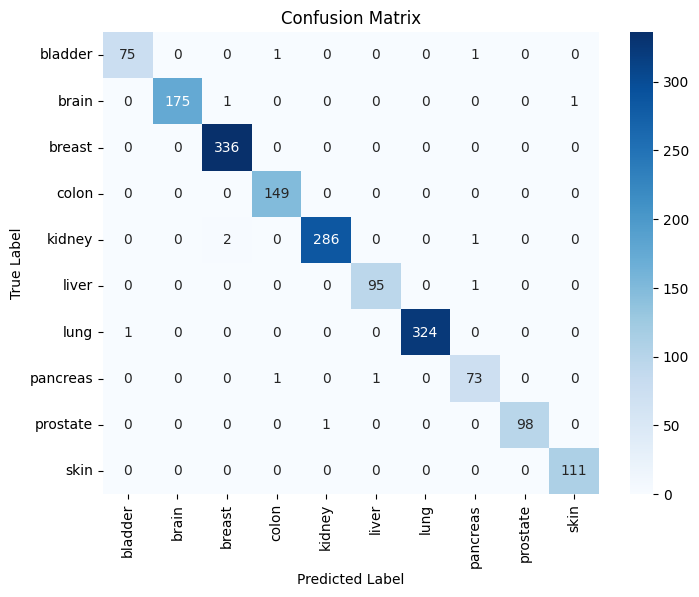

In [6]:
print("Verifying accuracy...")

# predict the output of the train dataset
pred_train = model_train.predict(all_data_train)
accuracy = accuracy_score(pred_train, all_labels_encoded_train)
print("Accuracy of the train: %.4f%%" % (accuracy * 100.0))

# predict the output of the validation dataset
pred_validation = model_train.predict(all_data_validation)
accuracy = accuracy_score(pred_validation, all_labels_encoded_validation)
print("Accuracy of the validation: %.4f%%" % (accuracy * 100.0))

# Calculate precision, recall and F1 score
precision = precision_score(all_labels_encoded_validation, pred_validation, average='macro')
recall = recall_score(all_labels_encoded_validation, pred_validation, average='macro')
f1 = f1_score(all_labels_encoded_validation, pred_validation, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# calculate the confusion matrix
confusion = sklearn.metrics.confusion_matrix(all_labels_encoded_validation, pred_validation)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Conclusion

We can see that the model generalized pretty well on the validation data from TCGA: perfect classification accuracy on training splot and almost perfect (99.3%) on validation split.

F1 score of 0.9902 also tells us the model performs well, as well as clean conusion matrix having almost all detections on the main diagonal.

Another model can be trained by changing the value of AUGMENTATION parameter in the code block at the beginning and re-running the whole notebook.

The next step is verifying how the model performs on the external validation dataset from another database, i.e. GEO.